#Import Libraries

In [ ]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import drive
from google.colab import files

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import EfficientNetV2B1

#Load Dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/Dataset/garbage_classification'

In [ ]:
source_path_battery = os.path.join(dataset_path, 'battery')
source_path_biological = os.path.join(dataset_path, 'biological')
source_path_brown_glass = os.path.join(dataset_path, 'brown-glass')
source_path_cardboard = os.path.join(dataset_path, 'cardboard')
source_path_clothes = os.path.join(dataset_path, 'clothes')
source_path_green_glass = os.path.join(dataset_path, 'green-glass')
source_path_metal = os.path.join(dataset_path, 'metal')
source_path_paper = os.path.join(dataset_path, 'paper')
source_path_plastic = os.path.join(dataset_path, 'plastic')
source_path_shoes = os.path.join(dataset_path, 'shoes')
source_path_trash = os.path.join(dataset_path, 'trash')
source_path_white_glass = os.path.join(dataset_path, 'white-glass')


!find /Dataset/garbage_classification/ -type f ! -name "*.jpg" -exec rm {} +

print(f"There are {len(os.listdir(source_path_battery))} images of battery.")
print(f"There are {len(os.listdir(source_path_biological))} images of biological.")
print(f"There are {len(os.listdir(source_path_brown_glass))} images of brow glass.")
print(f"There are {len(os.listdir(source_path_cardboard))} images of cardboard.")
print(f"There are {len(os.listdir(source_path_clothes))} images of clothes.")
print(f"There are {len(os.listdir(source_path_green_glass))} images of green-glass.")
print(f"There are {len(os.listdir(source_path_metal))} images of metal.")
print(f"There are {len(os.listdir(source_path_paper))} images of paper.")
print(f"There are {len(os.listdir(source_path_plastic))} images of plastic.")
print(f"There are {len(os.listdir(source_path_shoes))} images of shoes.")
print(f"There are {len(os.listdir(source_path_trash))} images of trash.")
print(f"There are {len(os.listdir(source_path_white_glass))} images of white glass.")

find: ‘/Dataset/garbage_classification/’: No such file or directory
There are 955 images of battery.
There are 1005 images of biological.
There are 617 images of brow glass.
There are 891 images of cardboard.
There are 5325 images of clothes.
There are 629 images of green-glass.
There are 769 images of metal.
There are 1050 images of paper.
There are 865 images of plastic.
There are 2007 images of shoes.
There are 697 images of trash.
There are 785 images of white glass.


In [ ]:
pd.DataFrame(os.listdir(dataset_path),columns=['Files_Name'])

,Files_Name
0,.DS_Store
1,metal
2,clothes
3,biological
4,shoes
5,battery
6,brown-glass
7,trash
8,cardboard
9,plastic


In [ ]:
files = []

for root, dir, filenames in os.walk(dataset_path):
  for filename in filenames:
    files.append(os.path.join(root, filename))

files = np.array(files)
np.random.shuffle(files)

labels = [os.path.basename(os.path.dirname(file_)) for file_ in files]


data = list(zip(files, labels))
dataframe = pd.DataFrame(data, columns=['Image', 'Label'])

dataframe

,Image,Label
0,/content/drive/My Drive/Dataset/garbage_classi...,battery
1,/content/drive/My Drive/Dataset/garbage_classi...,clothes
2,/content/drive/My Drive/Dataset/garbage_classi...,clothes
3,/content/drive/My Drive/Dataset/garbage_classi...,battery
4,/content/drive/My Drive/Dataset/garbage_classi...,shoes
...,...,...
15591,/content/drive/My Drive/Dataset/garbage_classi...,biological
15592,/content/drive/My Drive/Dataset/garbage_classi...,plastic
15593,/content/drive/My Drive/Dataset/garbage_classi...,trash
15594,/content/drive/My Drive/Dataset/garbage_classi...,clothes


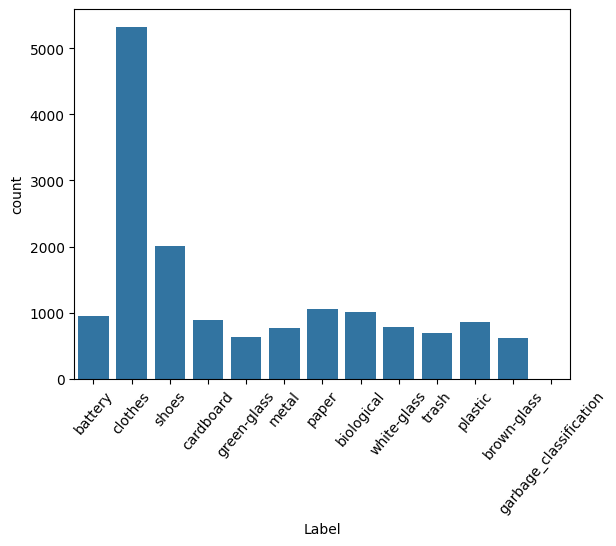

In [ ]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 50);

#Split Data

In [ ]:
NAME_DIR = dataset_path
BATCH = 64
TARGET_SIZE = (224, 224)
SPLIT = 0.2

In [ ]:
def split_dataset(name_dir=NAME_DIR, batch_size=BATCH, target_size=TARGET_SIZE, split=SPLIT):
  training = tf.keras.preprocessing.image_dataset_from_directory(
    name_dir,
    validation_split = split,
    subset = 'training',
    seed = 50,
    image_size = target_size,
    batch_size = batch_size,
    )

  validation = tf.keras.preprocessing.image_dataset_from_directory(
    name_dir,
    validation_split = split,
    subset = 'validation',
    seed = 100,
    image_size = target_size,
    batch_size = batch_size
    )

  print("Training set size:", len(training))
  print("Validation set size:", len(validation))


  return training, validation


In [ ]:
training, validation = split_dataset()

Found 15595 files belonging to 12 classes.
Using 12476 files for training.
Found 15595 files belonging to 12 classes.
Using 3119 files for validation.
Training set size: 195
Validation set size: 49


#Image Visualization

In [ ]:
name = training.class_names
name

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

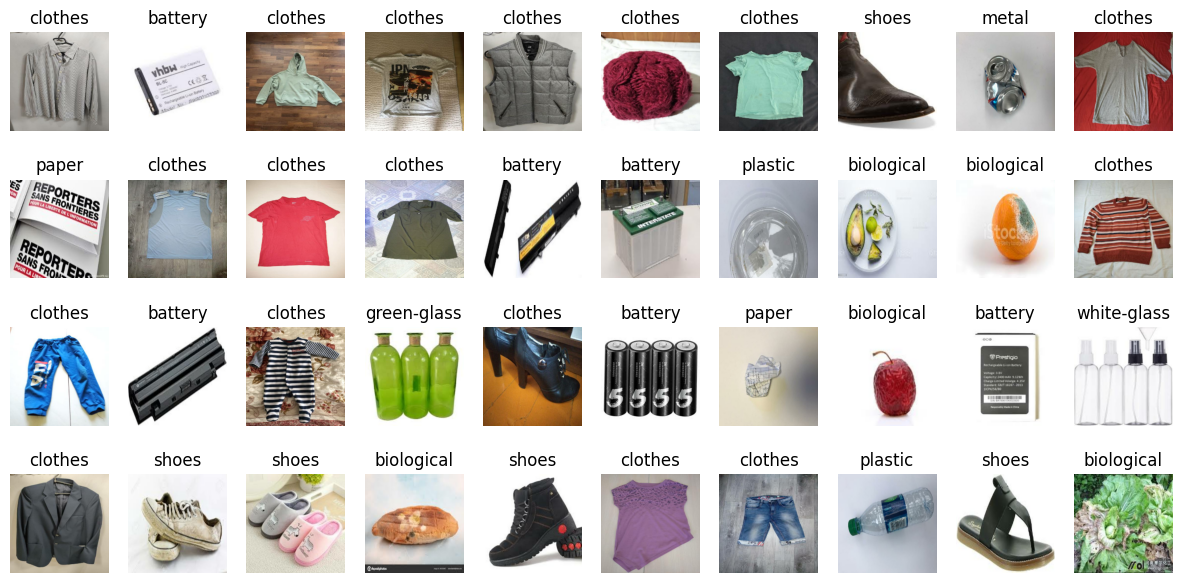

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in training.take(1):
  for i in range(40):
    ax = plt.subplot(8, 10, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(name[labels[i]])
    plt.axis('off')

#Create Model

In [ ]:
model_base = tf.keras.applications.EfficientNetV2B1(input_shape=(224,224,3), include_top=False, weights='imagenet')
model_base.trainable = False

28456008/28456008 [==============================] - 2s 0us/step


In [ ]:
def create_model():
  model = tf.keras.Sequential([
    model_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=12, activation='softmax')
    ])


  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Functio  (None, 7, 7, 1280)        6931124   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 12)                752652    
                                                                 
Total params: 7683776 (29.31 MB)
Trainable params: 752652 (2.87 MB)
Non-trainable params: 6931124 (26.44 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
checkpoint =ModelCheckpoint("ReCraftify_model.h5", save_best_only=True)
callbacks =EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(training,
                    epochs=50,
                    validation_data=validation,
                    callbacks=[checkpoint, callbacks]
                    )

Epoch 1/50
195/195 [==============================] - 4120s 21s/step - loss: 0.6706 - accuracy: 0.9041 - val_loss: 0.1419 - val_accuracy: 0.9727
Epoch 2/50
195/195 [==============================] - 63s 314ms/step - loss: 0.2172 - accuracy: 0.9684 - val_loss: 0.1180 - val_accuracy: 0.9833
Epoch 3/50
195/195 [==============================] - 59s 296ms/step - loss: 0.1337 - accuracy: 0.9804 - val_loss: 0.0910 - val_accuracy: 0.9878
Epoch 4/50
195/195 [==============================] - 58s 291ms/step - loss: 0.1053 - accuracy: 0.9867 - val_loss: 0.0948 - val_accuracy: 0.9907
Epoch 5/50
195/195 [==============================] - 67s 336ms/step - loss: 0.1255 - accuracy: 0.9838 - val_loss: 0.1329 - val_accuracy: 0.9904
Epoch 6/50
195/195 [==============================] - 58s 291ms/step - loss: 0.1081 - accuracy: 0.9877 - val_loss: 0.1153 - val_accuracy: 0.9901
Epoch 7/50
195/195 [==============================] - 61s 306ms/step - loss: 0.0922 - accuracy: 0.9893 - val_loss: 0.0911 - val_ac

In [ ]:
score, accuracy = model.evaluate(validation)
print(f'Test loss: {score: .4f}')
print(f'Test accuracy: {accuracy * 100:2f}%')

49/49 [==============================] - 11s 194ms/step - loss: 0.0854 - accuracy: 0.9897
Test loss:  0.0854
Test accuracy: 98.974031%


In [ ]:
histo = pd.DataFrame(history.history)
histo

,loss,accuracy,val_loss,val_accuracy
0,0.598690,0.922651,0.131419,0.976595
1,0.269205,0.967137,0.096914,0.987175
2,0.167424,0.980122,0.085352,0.989740
3,0.100194,0.986133,0.092959,0.988137
4,0.087366,0.989660,0.098857,0.991343
5,0.083462,0.988859,0.156968,0.989420
6,0.106352,0.989019,0.101347,0.992626
7,0.108880,0.988458,0.148076,0.990702
8,0.108873,0.989981,0.117524,0.991343
9,0.083708,0.991904,0.138473,0.992305


In [ ]:
def plot_training_and_val_history():
  plt.figure(figsize=(20,5))

  plt.subplot(1, 2, 2)
  plt.plot(histo['loss'], label='Training Loss')
  plt.plot(histo['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


  plt.plot(histo['accuracy'], label='Training Accuracy')
  plt.plot(histo['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

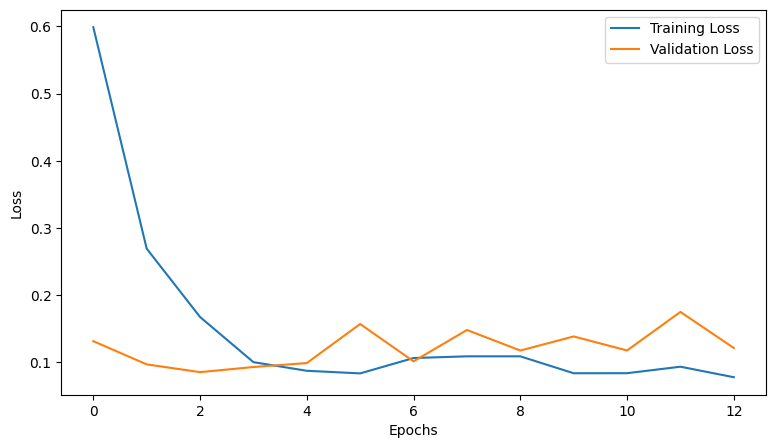

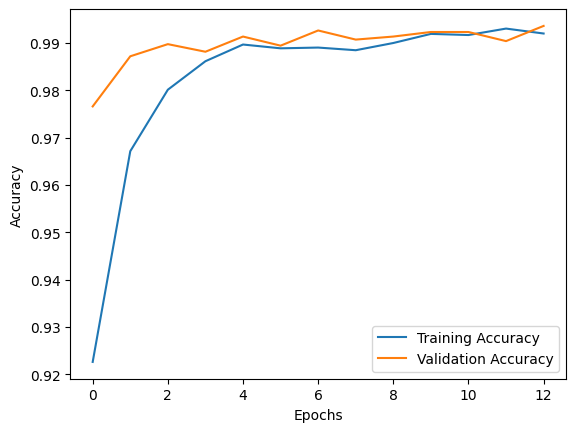

In [ ]:
plot_training_and_val_history()

#Predict

In [ ]:
from tensorflow.keras.preprocessing import image

def data_frame():
  X_val, y_val, y_pred = [], [], []
  for img, label in validation:
    y_val.extend(label.numpy())
    X_val.extend(img.numpy())
  prediction = model.predict(np.array(X_val))
  for i in prediction:
    y_pred.append(np.argmax(i))
  df=pd.DataFrame()
  df['Actual'],df['Prediction']=y_val,y_pred

  return df, X_val, y_val, y_pred

In [ ]:
df, X_val, y_val, y_pred = data_frame()
df

NameError: name 'validation' is not defined

In [ ]:
plt.figure(figsize=(15,15))
for i in range(40):
    ax = plt.subplot(8, 10, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{name[y_val[i]]} <--> {name[y_pred[i]]}')
    plt.axis("off")

In [ ]:
from tensorflow.keras.utils import img_to_array, load_img


class_mapping = {
    0: 'battery',
    1: 'biological',
    2: 'brown_glass',
    3: 'cardboard',
    4: 'clothes',
    5: 'green_glass',
    6: 'metal',
    7: 'paper',
    8: 'plastic',
    9: 'shoes',
    10: 'trash',
    11: 'white_glass'
}

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(224, 224))

  x=img_to_array(img)
  x /= 255.0
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=64)

  predicted_class_index = np.argmax(classes[0])
  predicted_label = class_mapping[predicted_class_index]
  print(f"File: {fn}")
  print(f"Predicted Class: {predicted_label}")

In [ ]:
files.download("ReCraftify_model.h5")

#Convert to TFLITE